## Simulation on the fully synthetic regression task

In [1]:
from mechanism_learn import pipeline as mlpipe
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

syn_data_dir = r"../test_data/synthetic_data/"

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.titlesize"] = 16

### Load datasets

In [2]:
testcase_dir = r"regression/"
X_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_conf.csv")
Y_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_conf.csv")
U_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "U_train_conf.csv")
Z_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Z_train_conf.csv")
X_train_conf = np.array(X_train_conf).reshape(-1,1)
Y_train_conf = np.array(Y_train_conf).reshape(-1,1)
U_train_conf = np.array(U_train_conf).reshape(-1,1)
Z_train_conf = np.array(Z_train_conf).reshape(-1,1)

X_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_conf.csv")
Y_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_conf.csv")
X_test_conf = np.array(X_test_conf).reshape(-1,1)
Y_test_conf = np.array(Y_test_conf).reshape(-1,1)

X_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_unconf.csv")
Y_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_unconf.csv")
X_test_unconf = np.array(X_test_unconf).reshape(-1,1)
Y_test_unconf = np.array(Y_test_unconf).reshape(-1,1)

### Assign counterfactual intervention values

In [ ]:
# Here we assume the counterfactual intervention values are uniformly distributed
intv_intval_num = 30
N = X_train_conf.shape[0]
Y_interv_values = np.linspace(np.mean(Y_train_conf) - 0.95*(np.max(Y_train_conf)- np.min(Y_train_conf)), 
                              np.mean(Y_train_conf) + 0.95*(np.max(Y_train_conf)- np.min(Y_train_conf)), 
                              intv_intval_num)
n_samples = [int(N/intv_intval_num)]*intv_intval_num

### Train a deconfounded linear regressor using mechanism learning

In [ ]:
ml_gmm_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                    mechanism_data = Z_train_conf, 
                                                    effect_data = X_train_conf, 
                                                    intv_values = Y_interv_values, 
                                                    dist_map = None, 
                                                    est_method = "multinorm"
                                                    )

ml_gmm_pipeline.cwgmm_fit(comp_k = 3,
                          max_iter = 1000,
                          tol = 1e-4,
                          init_method= "kmeans++",
                          cov_type = "full",
                          verbose = 2)

deconf_X_gmm, deconf_Y_gmm = ml_gmm_pipeline.cwgmm_resample(n_samples = n_samples, return_samples = True)

deconf_gmm_lr = ml_gmm_pipeline.deconf_model_fit(ml_model = LinearRegression())

### Train a deconfounded linear regressor using CB-based deconfounding method

In [ ]:
ml_cb_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                   mechanism_data = Z_train_conf, 
                                                   effect_data = X_train_conf, 
                                                   intv_values = Y_interv_values, 
                                                   dist_map = None, 
                                                   est_method = "multinorm"
                                                   )

deconf_X_cb, deconf_Y_cb = ml_cb_pipeline.cb_resample(n_samples = n_samples,
                                                      return_samples = True)

deconf_cb_lr = ml_cb_pipeline.deconf_model_fit(ml_model = LinearRegression())

### Train a confounded linear regressor

In [6]:
conf_lr = LinearRegression()
conf_lr = conf_lr.fit(X_train_conf, Y_train_conf.reshape(-1))

### Compare their regression lines

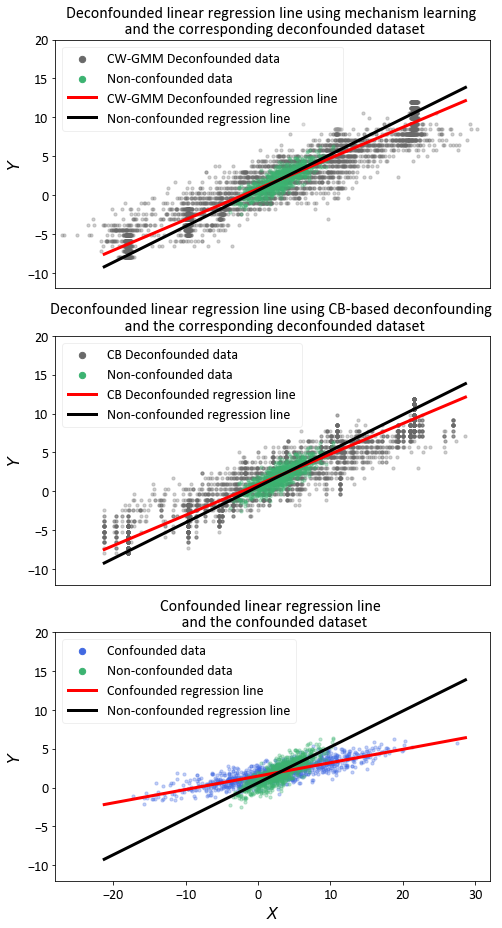

In [7]:
x_grid = np.linspace(np.min([np.min(X_train_conf), np.min(X_test_unconf)]),
                     np.max([np.max(X_train_conf), np.max(X_test_unconf)]), 
                     num=1000)
regLine_conf = conf_lr.predict(x_grid.reshape(-1,1))
regLine_deconf_gmm = deconf_gmm_lr.predict(x_grid.reshape(-1,1))
regLine_deconf_cb = deconf_cb_lr.predict(x_grid.reshape(-1,1))

unconf_lr = LinearRegression()
unconf_lr.fit(X_test_unconf, Y_test_unconf.reshape(-1,1))
regLine_unconf = unconf_lr.predict(x_grid.reshape(-1,1))
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 16

fig, axs = plt.subplots(3, 1, figsize=(7, 13))

# Plot deconfounded linear regression line on CW-GMM deconfounded dataset
ax = axs[0]
ax.scatter(deconf_X_gmm, deconf_Y_gmm, s=10, c='dimgrey', alpha=0.3, label="CW-GMM Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf_gmm, color='red', label="CW-GMM Deconfounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_ylabel(r"$Y$")
ax.set_xticks([])  
ax.set_ylim(-12, 20)
ax.set_xlim(-28, 32)
ax.set_title("Deconfounded linear regression line using mechanism learning \n and the corresponding deconfounded dataset")
legend = ax.legend(fontsize=14, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

# Plot deconfounded linear regression line on CB deconfounded dataset
ax = axs[1]
ax.scatter(deconf_X_cb, deconf_Y_cb, s=10, c='dimgrey', alpha=0.3, label="CB Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf_cb, color='red', label="CB Deconfounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_ylabel(r"$Y$")
ax.set_xticks([])  
ax.set_ylim(-12, 20)
ax.set_xlim(-28, 32)
ax.set_title("Deconfounded linear regression line using CB-based deconfounding \n and the corresponding deconfounded dataset")
legend = ax.legend(fontsize=14, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

# Plot confounded linear regression line on confounded dataset    
ax = axs[2]
ax.scatter(X_test_conf, Y_test_conf, s=10, c='royalblue', alpha=0.3, label="Confounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_conf, color='red', label="Confounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_ylabel(r"$Y$")
ax.set_xlabel(r"$X$")
ax.set_ylim(-12, 20)
ax.set_xlim(-28, 32)
ax.set_title("Confounded linear regression line \n and the confounded dataset")
legend = ax.legend(fontsize=14, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.show()

### Compare thier performance on the confounded and non-confounded test datasets

In [8]:
# Preditction on the non-confounded test set
y_pred_gmm_deconf_unconf = deconf_gmm_lr.predict(X_test_unconf)
y_pred_cb_deconf_unconf = deconf_cb_lr.predict(X_test_unconf)
y_pred_conf_unconf = conf_lr.predict(X_test_unconf)
# Preditction on the confounded test set
y_pred_gmm_deconf_conf = deconf_gmm_lr.predict(X_test_conf)
y_pred_cb_deconf_conf = deconf_cb_lr.predict(X_test_conf)
y_pred_conf_conf = conf_lr.predict(X_test_conf)

mse_gmm_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_gmm_deconf_unconf)
r2_gmm_deconf_unconf = r2_score(Y_test_unconf, y_pred_gmm_deconf_unconf)
mae_gmm_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_gmm_deconf_unconf)

mse_cb_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_cb_deconf_unconf)
r2_cb_deconf_unconf = r2_score(Y_test_unconf, y_pred_cb_deconf_unconf)
mae_cb_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_cb_deconf_unconf)

mse_conf_unconf = mean_squared_error(Y_test_unconf, y_pred_conf_unconf)
r2_conf_unconf = r2_score(Y_test_unconf, y_pred_conf_unconf)
mae_conf_unconf = mean_absolute_error(Y_test_unconf, y_pred_conf_unconf)

mse_gmm_deconf_conf = mean_squared_error(Y_test_conf, y_pred_gmm_deconf_conf)
r2_gmm_deconf_conf = r2_score(Y_test_conf, y_pred_gmm_deconf_conf)
mae_gmm_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_gmm_deconf_conf)

mse_cb_deconf_conf = mean_squared_error(Y_test_conf, y_pred_cb_deconf_conf)
r2_cb_deconf_conf = r2_score(Y_test_conf, y_pred_cb_deconf_conf)
mae_cb_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_cb_deconf_conf)

mse_conf_conf = mean_squared_error(Y_test_conf, y_pred_conf_conf)
r2_conf_conf = r2_score(Y_test_conf, y_pred_conf_conf)
mae_conf_conf = mean_absolute_error(Y_test_conf, y_pred_conf_conf)

print("Test on the non-confounded test set:")
print("deconfounded model using mechanism learning:")
print(f"MSE: {round(mse_gmm_deconf_unconf,3)}")
print(f"R2: {round(r2_gmm_deconf_unconf,3)}")
print(f"MAE: {round(mae_gmm_deconf_unconf,3)}")

print("-"*20)
print("deconfounded model using CB-based method:")
print(f"MSE: {round(mse_cb_deconf_unconf,3)}")
print(f"R2: {round(r2_cb_deconf_unconf,3)}")
print(f"MAE: {round(mae_cb_deconf_unconf,3)}")

print("-"*20)
print("Confounded model:")
print(f"MSE: {round(mse_conf_unconf,3)}")
print(f"R2: {round(r2_conf_unconf,3)}")
print(f"MAE: {round(mae_conf_unconf,3)}")

print("*"*30)
print("Test on the confounded test set:")
print("deconfounded model using mechanism learning:")
print(f"MSE: {round(mse_gmm_deconf_conf,3)}")
print(f"R2: {round(r2_gmm_deconf_conf,3)}")
print(f"MAE: {round(mae_gmm_deconf_conf,3)}")

print("-"*20)
print("deconfounded model using CB-based method:")
print(f"MSE: {round(mse_cb_deconf_conf,3)}")
print(f"R2: {round(r2_cb_deconf_conf,3)}")
print(f"MAE: {round(mae_cb_deconf_conf,3)}")

print("-"*20)
print("Confounded model:")
print(f"MSE: {round(mse_conf_conf,3)}")
print(f"R2: {round(r2_conf_conf,3)}")
print(f"MAE: {round(mae_conf_conf,3)}")

Test on the non-confounded test set:
deconfounded model using mechanism learning:
MSE: 0.647
R2: 0.677
MAE: 0.637
--------------------
deconfounded model using CB-based method:
MSE: 0.652
R2: 0.674
MAE: 0.639
--------------------
Confounded model:
MSE: 1.162
R2: 0.419
MAE: 0.855
******************************
Test on the confounded test set:
deconfounded model using mechanism learning:
MSE: 2.885
R2: -0.421
MAE: 1.356
--------------------
deconfounded model using CB-based method:
MSE: 2.817
R2: -0.387
MAE: 1.339
--------------------
Confounded model:
MSE: 0.595
R2: 0.707
MAE: 0.61
